In [46]:
import pandas as pd
from pymongo import MongoClient
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

import networkx as nx 

from nltk.tokenize import TweetTokenizer

from wordcloud import WordCloud

import tweepy
import time

from string import punctuation
from bson import json_util, ObjectId
from pandas.io.json import json_normalize
import json
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth',300)

APP_KEY="xLOajxwsYIf0vcDEJZDia25Ob"
APP_SECRET="z9K2L8e6BbVV6eUY05apuEWTqqCTse6rCOxWqX2Nb1aA2eeI9d"
OAUTH_TOKEN="30895751-9ZFWSUilQpeNc6trGdShEEErOdDtLfSM8W35rUsZa"
OAUTH_TOKEN_SECRET="gFzdNSa7tDr732PuTaHugkNjh1YKyrMua6Xi9h1ikshq4"

In [47]:
def mongo_to_dataframe(mongo_data):

        sanitized = json.loads(json_util.dumps(mongo_data))
        normalized = json_normalize(sanitized)
        df = pd.DataFrame(normalized)

        return df
    
def draw_graph_count(df, col):
    ax = sns.countplot(x=col, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()
    
def draw_word_cloud(tokens):
    texto_cloud = ' '.join(tokens)

    wc = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(texto_cloud) 
  
    # plot the WordCloud image                        
    plt.figure(figsize = (8, 8), facecolor = None) 
    plt.imshow(wc) 
    plt.axis("off") 
    plt.tight_layout(pad = 0) 

    plt.show()

def draw_network(df, nodes, source, target):
    G = nx.from_pandas_edgelist(df=df, source=source, target=target)
    G.add_nodes_from(nodes_for_adding=nodes.tolist())
    nx.draw(G, with_labels = True, node_color='lightgrey', node_size = 500, font_size = 10)

# Carga dos dados

## Consulta aos Tweets salvos no Mongo

Conexão e consulta dos tweets salvos mongodb a partir da coleta via streming utilizando o Apache NiFi. Carga dos dados no pandas dataframe.

In [48]:
host = '172.17.0.2'
port = 27017
collection = 'cemig'
db_name = 'cemig'
collection = 'raw_tweets'
collection_rt = 'raw_retweets'

conn = MongoClient(host, port)
db = conn[db_name]
cursor = db[collection].find({},{"_id":0,"id":1,"timestamp_ms":1,"text":1,'user.screen_name':1,'user.location':1,'user.followers_count':1,'user.friends_count':1})
df_tweets =  mongo_to_dataframe(cursor)


    

In [51]:
df_tweets["tempo"] = pd.to_datetime(df_tweets['timestamp_ms'], unit='ms').dt.tz_localize('America/Sao_Paulo')
df_tweets["data"] = df_tweets["tempo"].dt.date
df_tweets["text"] = df_tweets["text"].str.replace('https:\/\/.*\s?','')

df_tweets["user_retweeted"] = df_tweets["text"].str.extract('^RT \@([\w]+)\:', expand=False)
df_tweets["user_retweeted"] = df_tweets["user_retweeted"].fillna("")

df_tweets.to_csv(path_or_buf='tweets.csv', index=False)


In [50]:
df_tweets.columns = ['id','text','timestamp_ms','user_followers_count','user_friends_count','user_location','user_screen_name','tempo','data','user_retweeted']

df_tweets[['id','text', 'user_followers_count','user_friends_count','user_location','user_screen_name','data','user_retweeted']].head(10)

,id,text,user_followers_count,user_friends_count,user_location,user_screen_name,data,user_retweeted
0,1107042314097229824,"CEMIG ta vacilona hoje em, assim não dá",507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,
1,1107052443580420096,Ficar sem luz e foda essa loja da Cemig,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,
2,1107053694523228160,Cemig zuando os pratence hihihi,382,295,ciúmentolandia,sou_geise,2019-03-16,
3,1107072220281688064,@BETHEVITAS @mxrcone CEMIG curtiu isso.,1461,1466,"Minas Gerais, Brasil",jkbrunno,2019-03-17,
4,1107098836516962305,Recado dos Eletricitários em defesa da CEMIG - FNU,63,1697,Rio de Janeiro - Brasil,magu5,2019-03-17,
5,1107108700936962054,Minha tia ligou pra cemig e falou. Mal começou a chover e a nossa luz já tá igual pisca pisca de Natal 😂😂😂😂,73,268,None,LLeijoto,2019-03-17,
6,1107115671501053952,Começou a chover daqui uns 30 minutos a Cemig corta a luz,73,209,"Alpercata, Brasil",HygorRibeiro16,2019-03-17,
7,1107122569692545024,"CEMIG Serviços S.A., vamos ver se você entende esse GIF.",108,338,None,JReis_MB,2019-03-17,
8,1107123548622123008,"@joaoamoedonovo até agora nada do ""novo"" ter anunciado a venda das 2 estatais CEMIG E COPASA, que estão oprimindo o povo",105,549,Brasil,Desmio,2019-03-17,
9,1107124187641069568,RT @yasmimfcandido: Essa cemig tá me tirando hoje,312,412,Na minha casa 🤙,alvesanna17,2019-03-17,yasmimfcandido


## Carga do Dicionário de Palavras e Polaridade

Carga e parse do arquivo contendo palavras e polaridades
Criação de um dicionário contendo palavra e polaridade

In [6]:
df_arq = pd.read_csv('SentiLex-PT02/SentiLex-flex-PT02.txt', header=None, names=['col'], sep='#')
df_arq = df_arq[~df_arq.col.str.contains("IDIOM")]

df_sentilex = df_arq.col.str.extract(r'^(?P<palavra>.*),.*\.PoS.*=(?P<polaridade>.?[0-9]);ANOT', expand=True)
df_sentilex = pd.Series(df_sentilex.polaridade.values,index=df_sentilex.palavra).to_dict()




## Criando DataFrame com os tokens extraídos dos Tweets

In [7]:
df_tokens = pd.DataFrame()

for index, row in df_tweets.iterrows():
    palavras = word_tokenize(row['text'].lower())
    sw = set(stopwords.words('portuguese') + list(punctuation) + list(['cemig','…','¿','...','-…','https','rt','pra','r','é','tá']))
    
    df_token_tmp = pd.DataFrame()
    df_token_tmp["tokens"] = [palavra for palavra in palavras if palavra not in sw]
    df_token_tmp["id"] = row['id']
    df_token_tmp["polaridade"] = df_token_tmp["tokens"].apply(df_sentilex.get)
    
    #print(df_token_tmp)
    df_tokens = df_tokens.append(df_token_tmp, ignore_index=True)
#    df_token_tmp["tokens"] = 
#    df_tokens["id"] = row['id']
        
df_tweets_tokens = df_tokens.set_index('id').join(df_tweets.set_index('id'))
df_tweets_tokens = df_tweets_tokens.fillna('0')


In [8]:
df_tweets_tokens[['tokens','polaridade','timestamp_ms','user_followers_count','user_friends_count','user_location','user_screen_name','data','user_retweeted']].head(10)

,tokens,polaridade,timestamp_ms,user_followers_count,user_friends_count,user_location,user_screen_name,data,user_retweeted
id,,,,,,,,,
1107042314097229824,ta,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,
1107042314097229824,vacilona,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,
1107042314097229824,hoje,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,
1107042314097229824,assim,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,
1107042314097229824,dá,0,1552774430189,507,423,"Minas Gerais, Brasil",MeloSahra,2019-03-16,
1107052443580420096,ficar,0,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,
1107052443580420096,luz,0,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,
1107052443580420096,foda,0,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,
1107052443580420096,loja,0,1552776845246,152,344,"Governador Valadares, Brasil",R_Freitas21,2019-03-16,


# Análise dos Dados

## Distribuição dos Tweets por dia

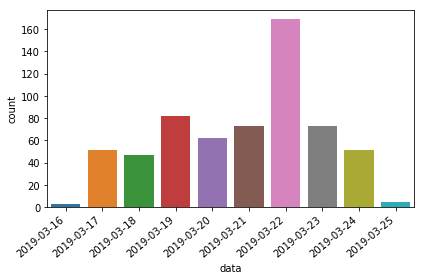

In [9]:
draw_graph_count(df_tweets, "data")

## Contagem de frequência das palavras

Listando as 10 mais frequentes

In [10]:
df_tweets_tokens.groupby('tokens').tokens.count().nlargest(10)

tokens
energia          61
luz              60
cmig4            54
cmig-n1          49
mil              39
renova           37
camarote         36
romeuzema        33
anos             32
independência    31
Name: tokens, dtype: int64

## Nuvem das palavras mais frequentes 

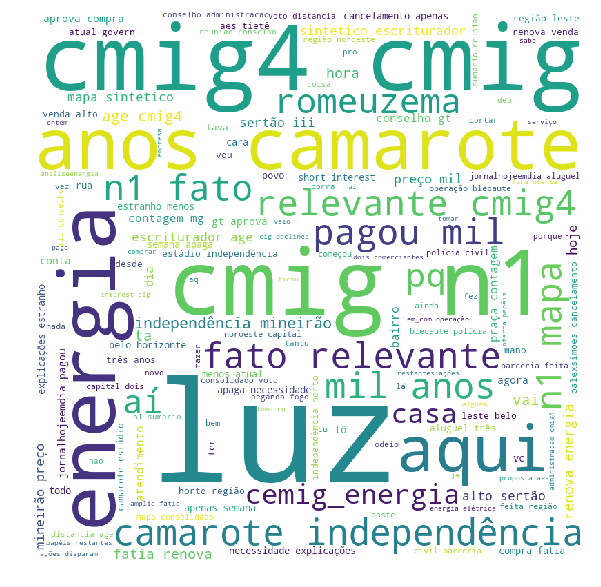

In [11]:
draw_word_cloud(df_tweets_tokens.tokens)

## CMIG4: Avaliando a ocorrência da palavra

In [12]:
df_cmig4 = df_tweets_tokens[['text','data']].loc[df_tweets_tokens['tokens'] == 'cmig4']
df_cmig4.head(5)

,text,data
id,,
1108315694775492609,Cemig para Abril de 2019 😍 - gráfico de #CMIG4,2019-03-20
1108317267865952256,#CMIG4 - Cemig para Abril de 2019 😍 - TradingView -,2019-03-20
1108936597116903424,$CMIG4 $RNEW11 \n\nCelebração de Contrato para Aquisição de Participação na Renova Energia S.A.\n(“Renova”) e Realizaç…,2019-03-22
1109062517735731200,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19,2019-03-22
1109062519933554688,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19,2019-03-22


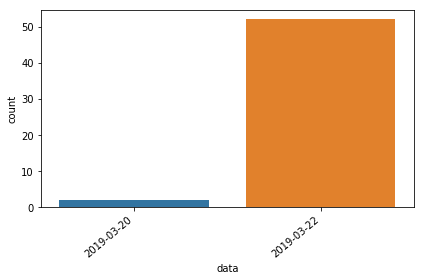

In [13]:
draw_graph_count(df_cmig4, "data")

O termo refere-se ao código do papel CEMIG negociado na bolsa de valores. Conforme observado na lista de tweets e data de propagação, tem relação com o informe de fato relevante encaminhado pela CEMIG ao mercado de ações.

## CAMAROTE: Avaliando a ocorrência palavra

In [14]:
df_camarote = df_tweets_tokens[['text','user_screen_name','data','user_retweeted']].loc[df_tweets_tokens['tokens'] == 'camarote']
df_camarote.head(5) 

,text,user_screen_name,data,user_retweeted
id,,,,
1109215677053837313,"Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n",jornalhojeemdia,2019-03-22,
1109215897464512515,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n",REGINALDOGALO10,2019-03-22,jornalhojeemdia
1109216983755698176,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n",digaormf,2019-03-22,jornalhojeemdia
1109217168451883009,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n",rafael_fr2,2019-03-22,jornalhojeemdia
1109218880659079170,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n",sracansada,2019-03-22,jornalhojeemdia


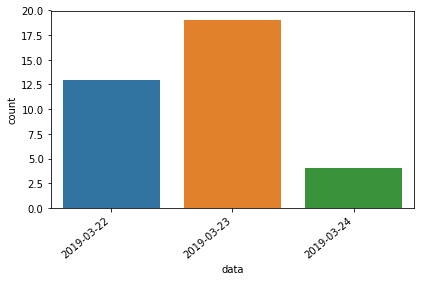

In [15]:
draw_graph_count(df_camarote, "data")

O termo tem relação com notícia veiculada pelo jornal Hoje em Dia, propagada entre os dias 22 e 24 de março. Segundo o jornal, a CEMIG teria pago o valor de 990 mil por 3 anos de camarote no estádio independência. Ainda segundo o jornal, o mesmo serviço poderia ter sido contratado no Minerião pelo valor de 390 mil.

Podemos observar que outros termos que aparecem na lista dos mais frequentes tem relação com esse mesmo fato: [mil, independência].

## Contagem de frequência das palavras com polaridade Negativa

Listando as 10 mais frequentes

In [16]:
df_tweets_tokens_neg = df_tweets_tokens.loc[df_tweets_tokens['polaridade'] == '-1']
df_tweets_tokens_neg.groupby('tokens').tokens.count().nlargest(10)

tokens
venda       23
apaga       14
odeio       12
estranho    10
pisca        6
apagava      5
caiu         5
derrotas     5
falta        5
vender       5
Name: tokens, dtype: int64

## Nuvem das palavras mais frequentes com polaridade negativa  

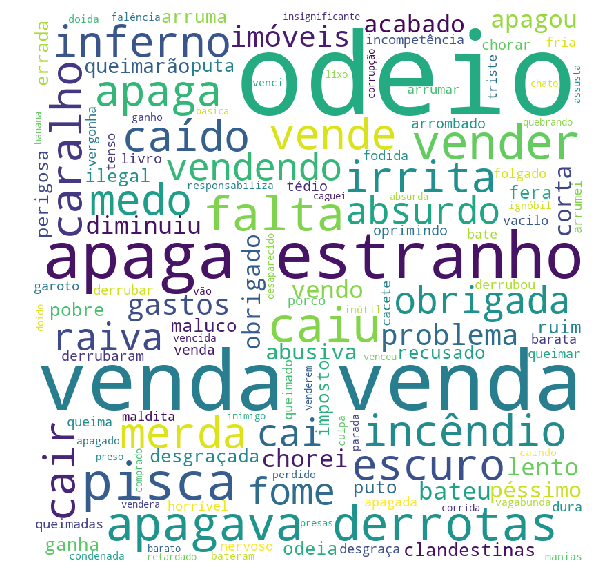

In [17]:
draw_word_cloud(df_tweets_tokens_neg.tokens)


## VENDA: Avaliando a ocorrência palavra

** Tweets **

In [18]:
df_venda = df_tweets_tokens_neg[['text','user_screen_name','user_retweeted','data']].loc[df_tweets_tokens_neg['tokens'] == 'venda']
df_venda

,text,user_screen_name,user_retweeted,data
id,,,,
1107123548622123008,"@joaoamoedonovo até agora nada do ""novo"" ter anunciado a venda das 2 estatais CEMIG E COPASA, que estão oprimindo o povo",Desmio,,2019-03-17
1107656184926998528,"Vejam o péssimo atendimento da Cemig, 20 minutos para pegar uma senha de atendimento, na Agência de Venda Nova!…",renato_artur,,2019-03-18
1107657455771758592,"RT @renato_artur: Vejam o péssimo atendimento da Cemig, 20 minutos para pegar uma senha de atendimento, na Agência de Venda Nova!#CEMIG htt…",helberthadm,renato_artur,2019-03-18
1109060826328166400,Conselho da Cemig GT aprova compra de fatia na Renova e venda de Alto Sertão III -,jornaltijucas,,2019-03-22
1109061194986459136,Conselho da Cemig GT aprova compra de fatia na Renova e venda de Alto Sertão III -,jornaltijucas,,2019-03-22
1109061195003236354,Conselho da Cemig GT aprova compra de fatia na Renova e venda de Alto Sertão III -,jornaltijucas,,2019-03-22
1109062989443973120,Conselho da Cemig GT aprova compra de fatia na Renova e venda de Alto Sertão III,INSTARBrazil,,2019-03-22
1109063169673170944,Conselho da Cemig GT aprova compra de fatia na Renova e venda de...,bomfeli,,2019-03-22
1109065486787112965,Conselho da Cemig GT aprova compra de fatia na Renova e venda de Alto Sertão III,jornalfloripa,,2019-03-22


** Distribuição **

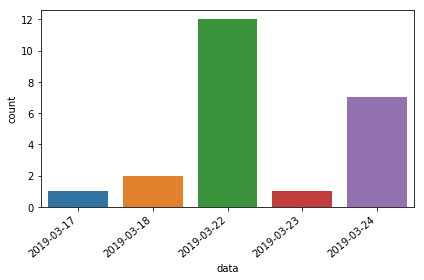

In [19]:
draw_graph_count(df_venda, "data")

A alta ocorrência do termo tem relação com dois fatos. O primeiro é a informação propagada no dia 22/03, de compra por parte da CEMIG de fatia da empresa Renova, e **venda** do complexo eólico de Alto Sertão III. Esse fato está relacionado ao comunicado enviado pela empresa ao mercado, no mesmo dia 22/03, razão da grande ocorrência do termo CMIG4, avaliado anteriormente.

Outra razão para alta ocorrência do termo tem origem nos tweets propagados no dia 24/03, relacionados à notícia de que a CEMIG está vendendo alguns de seus imóveis, e a reação de usuários à essa notícia, pedindo que o governador Romeu Zema aproveite a ocasião para vender (ou privatizar) a empresa.

## APAGA e ESTRANHO: Avaliando a ocorrência das palavras

** Tweets: APAGA **

In [20]:
df_apaga = df_tweets_tokens_neg[['text','user_screen_name','user_retweeted','data']].loc[df_tweets_tokens_neg['tokens'] == 'apaga']
df_apaga

,text,user_screen_name,user_retweeted,data
id,,,,
1107133154068971521,@BellaMoreira8 e a minha que tá o dia todo “apaga a luz e deixa o tempo passar BABY VOCÊ NÃO PERDE POR ESPERAR APAG…,JujubaMS,,2019-03-17
1107417138879438849,"Cemig, se for pra piscar a luz de 10 em 10s apaga essa porra logo caralho\n\nPelo menos não queima o resto do meu PC",danielpontello,,2019-03-17
1107828522687565824,Luz Aq de casa tá acende apaga acende apaga. Decide logo se vai ter apagão ou não cemig,PinheiroRodson,,2019-03-19
1107828522687565824,Luz Aq de casa tá acende apaga acende apaga. Decide logo se vai ter apagão ou não cemig,PinheiroRodson,,2019-03-19
1109210554269384705,"O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual…",oalexsimoes,,2019-03-22
1109210645096996867,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",Tonin_Duarte,oalexsimoes,2019-03-22
1109211591860514816,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",RaphaCristhian,oalexsimoes,2019-03-22
1109212636061810688,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",Nando_Lango,oalexsimoes,2019-03-22
1109215638982180865,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",0648f5af88614a9,oalexsimoes,2019-03-22


** Distribuição: APAGA **

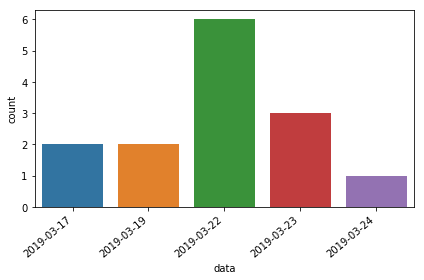

In [21]:
draw_graph_count(df_apaga, "data")


A maior ocorrência da palavra apaga está relacionada ao caso do camarote alugado pela CEMIG no independência, divulgado em um tweet do usuário @oalexsimoes  

In [22]:
df_estranho = df_tweets_tokens_neg[['text','data']].loc[df_tweets_tokens_neg['tokens'] == 'estranho']
df_estranho.head(5)

,text,data
id,,
1109210554269384705,"O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual…",2019-03-22
1109210645096996867,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",2019-03-22
1109211591860514816,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",2019-03-22
1109212636061810688,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",2019-03-22
1109215638982180865,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…",2019-03-22


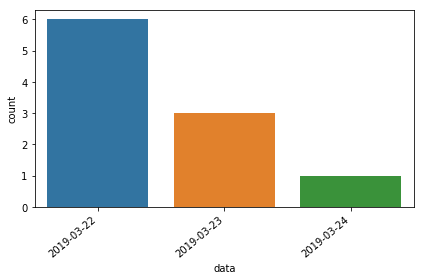

In [23]:
draw_graph_count(df_estranho, "data")

A palavra estranho também está relacionada ao mesmo tweet do usuário @oalexsimoes. A distribuição dos tweets que contém a palavra estranho, a partir do dia 22/03, é a mesma da palavra apaga a partir da mesma data.

## Contagem de frequência das palavras com polaridade Positiva

Listando as 10 mais frequentes

In [24]:
df_tweets_tokens_pos = df_tweets_tokens.loc[df_tweets_tokens['polaridade'] == '1']
df_tweets_tokens_pos.groupby('tokens').tokens.count().nlargest(10)

tokens
energia       61
relevante     21
belo          10
voto           7
boa            3
cedo           3
certíssimo     3
eficiente      3
abençoada      2
aguenta        2
Name: tokens, dtype: int64

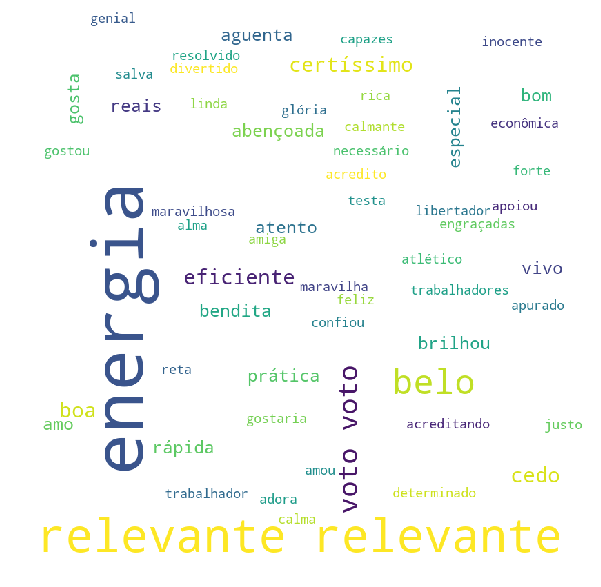

In [25]:
draw_word_cloud(df_tweets_tokens_pos.tokens)


In [26]:
df_energia = df_tweets_tokens_pos[['text','data','user_location']].loc[df_tweets_tokens_pos['tokens'] == 'energia']
df_energia.head(10)

,text,data,user_location
id,,,
1107125367767207936,"CEMIG Serviços S.A., vocês conseguiriam me recomendar alguma empresa de fornecimento de energia elétrica? A empresa…",2019-03-17,0
1107138321044647938,ta faltando energia aqui Cemig \nbunita,2019-03-17,Timothy City
1107145095013433344,"caiu a energia e vou dormir no valor, valeu Cemig.",2019-03-17,"Ipatinga, Minas Gerais"
1107338090975236097,que maravilha ein cemig sem estar chovendo to sem energia,2019-03-17,0
1107380419018797064,"Eu tô pensando é como vamos trabalhar na segunda pós sunsetville, mas tudo bem \nCemig vai ter que me dar energia 😂",2019-03-17,"Belo Horizonte, Minas Gerais"
1107417158668247040,Cemig eu te odeio pq se faltar energia vou surtar nem jantei ainda odeio comer no escuro,2019-03-17,+035
1107420107767275520,RT @helena__carvlho: Cemig eu te odeio pq se faltar energia vou surtar nem jantei ainda odeio comer no escuro,2019-03-17,Na puta que pariu
1107482804529565701,Caralho o motivo de ter acabado a energia é q pego fogo no negócio da Cemig slc bicho q medo desses troço,2019-03-18,"Itajubá, Brasil"
1107599066307969025,"@cemig_energia RT @cemig_energia #Efficientia: A #empresa de #serviços de #energia da #Cemig, vai investir até R$ 5…",2019-03-18,Franca


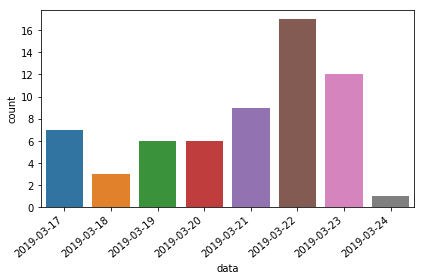

In [27]:
draw_graph_count(df_energia, "data")


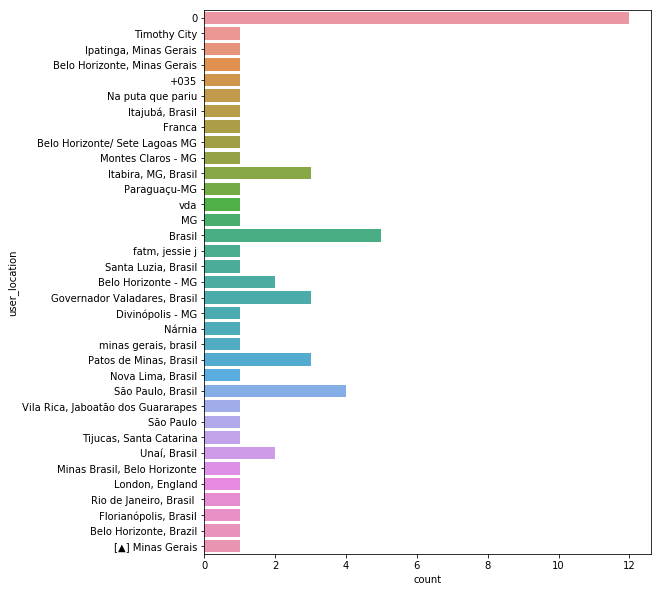

In [28]:
plt.figure(figsize=(8,10))
ax = sns.countplot(y="user_location", data=df_energia)
plt.show()

In [29]:
df_relevante = df_tweets_tokens_pos[['text','data']].loc[df_tweets_tokens_pos['tokens'] == 'relevante']
df_relevante.head(5)

,text,data
id,,
1109062517735731200,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19,2019-03-22
1109062519933554688,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19,2019-03-22
1109062601764495361,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19,2019-03-22
1109062604159356928,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19,2019-03-22
1109062646630887427,$CMIG4 - CEMIG (CMIG-N1) - Fato Relevante - 21/03/19,2019-03-22


# Usuários mais influentes

## Usuários mais retweetados no período

In [30]:
df_retweets = df_tweets.loc[~(df_tweets['user_retweeted'] == "")]
df_retweets.groupby('user_retweeted').user_retweeted.count().nlargest(10)

user_retweeted
jornalhojeemdia    19
oalexsimoes         9
cemig_energia       6
em_com              6
AnaliseEnergia      5
GeraldodeMorais     3
gustavonolascoB     3
lopaugomes          3
lxcerdz             3
AssisMarinhodf      2
Name: user_retweeted, dtype: int64

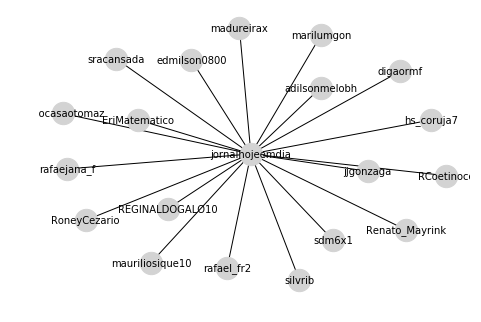

In [31]:
df_retweets_1 = df_tweets[['user_screen_name','user_retweeted','text']].loc[~(df_tweets['user_retweeted']!="jornalhojeemdia")]
draw_network(df_retweets_1, df_retweets_1.user_screen_name, 'user_screen_name', 'user_retweeted')


In [32]:
df_retweets_1

,user_screen_name,user_retweeted,text
465,REGINALDOGALO10,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"
467,digaormf,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"
468,rafael_fr2,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"
469,sracansada,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"
471,hs_coruja7,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"
473,silvrib,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"
477,RCoetinoco,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"
480,Renato_Mayrink,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"
482,edmilson0800,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"
511,RoneyCezario,jornalhojeemdia,"RT @jornalhojeemdia: Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n"


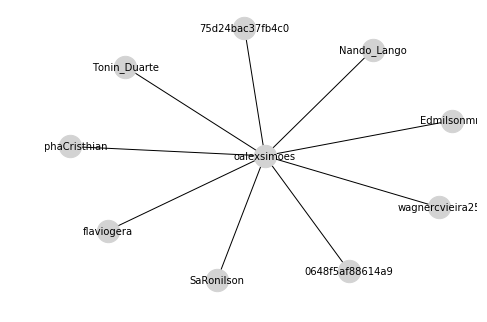

In [33]:
df_retweets_2 = df_tweets[['user_screen_name','user_retweeted','text']].loc[~(df_tweets['user_retweeted']!="oalexsimoes")]
draw_network(df_retweets_2, df_retweets_2.user_screen_name, 'user_screen_name', 'user_retweeted')


In [34]:
df_retweets_2

,user_screen_name,user_retweeted,text
458,Tonin_Duarte,oalexsimoes,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…"
459,RaphaCristhian,oalexsimoes,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…"
461,Nando_Lango,oalexsimoes,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…"
463,0648f5af88614a9,oalexsimoes,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…"
483,Edmilsonmm,oalexsimoes,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…"
496,wagnercvieira25,oalexsimoes,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…"
519,SaRonilson,oalexsimoes,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…"
532,flaviogera,oalexsimoes,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…"
565,75d24bac37fb4c0,oalexsimoes,"RT @oalexsimoes: O cancelamento, há apenas uma semana, não apaga a necessidade de explicações. Muito estranho!!!! Pelo menos o atual govern…"


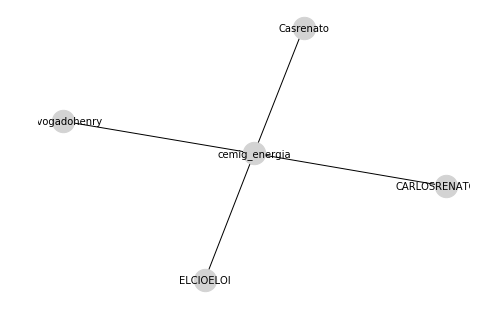

In [35]:
df_retweets_3 = df_tweets[['user_screen_name','user_retweeted','text']].loc[~(df_tweets['user_retweeted']!="cemig_energia")]
draw_network(df_retweets_3, df_retweets_3.user_screen_name, 'user_screen_name', 'user_retweeted')


In [36]:
df_retweets_3

,user_screen_name,user_retweeted,text
69,advogadohenry,cemig_energia,"RT @cemig_energia: A Cemig Geração Distribuída (Cemig GD) inaugurou em Janaúba, no Norte de Minas, a primeira usina de minigeração destinad…"
147,Casrenato,cemig_energia,"RT @cemig_energia: As ligações clandestinas na rede elétrica, os chamados ""gatos"", são uma prática perigosa e ilegal. Fique atento! Chame a…"
537,Casrenato,cemig_energia,"RT @cemig_energia: Caso veja fios elétricos caídos sobre um veículo, não se aproxime; se estiver dentro dele, evite sair.\nCaso seja necessá…"
542,ELCIOELOI,cemig_energia,"RT @cemig_energia: Caso veja fios elétricos caídos sobre um veículo, não se aproxime; se estiver dentro dele, evite sair.\nCaso seja necessá…"
604,Casrenato,cemig_energia,"RT @cemig_energia: Mantenha sua geladeira ligada! Desligar a geladeira durante a noite reduz a durabilidade de seus alimentos, além de não…"
606,CARLOSRENATOFR2,cemig_energia,"RT @cemig_energia: Mantenha sua geladeira ligada! Desligar a geladeira durante a noite reduz a durabilidade de seus alimentos, além de não…"


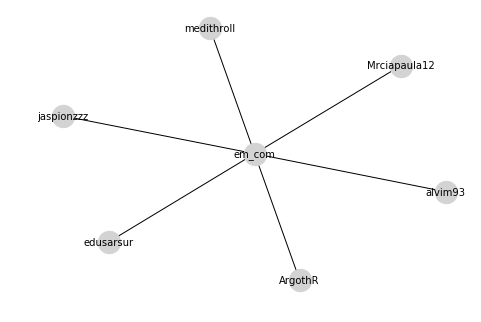

In [37]:
df_retweets_4 = df_tweets[['user_screen_name','user_retweeted','text']].loc[~(df_tweets['user_retweeted']!="em_com")]
draw_network(df_retweets_4, df_retweets_4.user_screen_name, 'user_screen_name', 'user_retweeted')



In [38]:
df_retweets_4

,user_screen_name,user_retweeted,text
178,medithroll,em_com,"RT @em_com: Operação Blecaute, da Polícia Civil em parceria com a Cemig, foi feita na Região Noroeste da capital. Dois comerciantes foram p…"
180,edusarsur,em_com,"RT @em_com: Operação Blecaute, da Polícia Civil em parceria com a Cemig, foi feita na Região Noroeste da capital. Dois comerciantes foram p…"
187,alvim93,em_com,"RT @em_com: Operação Blecaute, da Polícia Civil em parceria com a Cemig, foi feita na Região Noroeste da capital. Dois comerciantes foram p…"
188,ArgothR,em_com,"RT @em_com: Operação Blecaute, da Polícia Civil em parceria com a Cemig, foi feita na Região Noroeste da capital. Dois comerciantes foram p…"
189,jaspionzzz,em_com,"RT @em_com: Operação Blecaute, da Polícia Civil em parceria com a Cemig, foi feita na Região Noroeste da capital. Dois comerciantes foram p…"
197,Mrciapaula12,em_com,"RT @em_com: Operação Blecaute, da Polícia Civil em parceria com a Cemig, foi feita na Região Noroeste da capital. Dois comerciantes foram p…"


## Usuários com mais seguidores

In [39]:
df_tweets.groupby('user_screen_name').user_followers_count.max().nlargest(10)

user_screen_name
exame              2390173
em_com              497706
OficialBHTRANS      338156
otempo              276193
epocanegocios       209312
jornalhojeemdia     144154
portaluai            87909
CIObrasil            25533
cemig_energia        21620
SunoResearchcom      19466
Name: user_followers_count, dtype: int64

In [40]:
df_exame = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'exame']
df_exame.head(5)

,text,data
336,Conselho da Cemig GT aprova compra de fatia na Renova,2019-03-22


In [41]:
df_em_com = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'em_com']
df_em_com.head(5)

,text,data
177,"Operação Blecaute, da Polícia Civil em parceria com a Cemig, foi feita na Região Noroeste da capital. Dois comercia…",2019-03-19


In [42]:
df_OficialBHTRANS = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'OficialBHTRANS']
df_OficialBHTRANS.head(5)


,text,data
315,"19h45 AV. AMAZONAS | Sentido bairro: Trânsito com trechos intensos, mas fluindo entre Av. do Contorno / Expominas e…",2019-03-21


In [43]:
df_otempo = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'otempo']
df_otempo.head(5)


,text,data
65,Marco Antônio Lage assume comunicação da Cemig mirando gestão eficiente,2019-03-18


In [44]:
df_epocanegocios = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'epocanegocios']
df_epocanegocios.head(5)


,text,data
407,"Antes dos anúncios desta semana, a Renova já havia recusado uma oferta da canadense Brookfield e da própria AES Tie…",2019-03-22


In [45]:
df_jornalhojeemdia = df_tweets[['text','data']].loc[df_tweets['user_screen_name'] == 'jornalhojeemdia']
df_jornalhojeemdia.head(5)

,text,data
464,"Cemig pagou R$ 990 mil por 3 anos de camarote no Independência; no Mineirão, preço seria R$ 390 mil\n",2019-03-22
538,"Pelo ""aluguel"" por três anos de um camarote do Estádio Independência, no Horto, na região Leste de Belo Horizonte,…",2019-03-23
